In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load data

In [2]:
train = np.loadtxt("data/EMGaussian.data")
test = np.loadtxt("data/EMGaussian.test")

# Define functions

## Gaussian Kernels
Allow to compute the pdf and log_pdf of several d-dimensional points for several gaussian kernels simultaneously

In [3]:
class GaussianKernels:
    
    def __init__(self, means, covariances):
        self.states, self.dim = means.shape
        self.means = means
        self.covariances = covariances

    @property
    def means(self):
        return self._means
    
    @property
    def covariances(self):
        return self._covariances
    
    @means.setter
    def means(self, means):
        self._means = means
    
    @covariances.setter
    def covariances(self, covariances):
        self._covariances = covariances
        self._covariance_cache()
        
    def _covariance_cache(self):
        self.invcov = np.linalg.inv(self._covariances)
        self.covdet = np.linalg.det(self._covariances)
        self.factor = 1.0 / np.sqrt(((2.0 * math.pi) ** self.dim) * self.covdet)
        self.logfac = np.log(self.factor)
        
    def log_pdf(self, x):
        xc = x.reshape(-1, 1, self.dim) - self._means[None, :, :]
        p1 = np.sum(xc[:, :, None] * self.invcov[None, :, :], axis=-1)
        return self.logfac - 0.5 * np.sum(p1 * xc, axis=-1)

## Q1/Q4/Q8 GaussianHMM
Core of the homework : allow to define the initial probabilities, the transition, and the mean and covariances of the gaussian emission node. One can then predict the state of a hidden node q_t given T observations (filtering) using predict function (or directly using the gamma return by alpha_beta). Also implements the EM algorithm to estimate the parameters

In [4]:
def log_sum_exp(terms, axis=0):
    a = np.max(terms, axis=axis)
    return a + np.log(np.sum(np.exp(terms - np.expand_dims(a, axis=axis)), axis=axis))

class GaussianHMM:
    
    def __init__(self, states, init_prob, transition_prob, means, covariances):
        self.states = states
        self.init_prob = init_prob
        self.transition_prob = transition_prob
        self.emissions = GaussianKernels(means, covariances)

    def alpha_beta(self, observations):
        
        T = len(observations)
        
        log_init_prob = np.log(self.init_prob + 1e-8)
        log_transitions = np.log(self.transition_prob)
        log_pdf_observations = self.emissions.log_pdf(observations)
        
        # Alpha recursion
        alpha = np.empty((T, self.states))
        
        alpha[0] = log_pdf_observations[0] + log_init_prob
        for t in range(1, T):
            alpha[t] = (
                log_pdf_observations[t] + 
                log_sum_exp(alpha[t-1][:, None] +
                            log_transitions,
                            axis=0)
            )
        
        # Beta recursion
        beta = np.empty((T, self.states))
        
        beta[T-1] = 0
        for t in range(T-2, -1, -1):
            beta[t] = (
                log_sum_exp(beta[t+1] +
                            log_transitions +
                            log_pdf_observations[t+1],
                            axis=-1)
            )

        log_likelihood = log_sum_exp(alpha[0] + beta[0])
        
        # Calculate gamma
        gamma = alpha + beta - log_likelihood
        
        # Calculate xi
        xi = (alpha[:-1][:, :, None] + beta[1:][:, None, :] +
              log_transitions[None, :, :] +
              log_pdf_observations[1:][:, None, :] -
              log_likelihood)
        
        return np.exp(alpha), np.exp(beta), np.exp(gamma), np.exp(xi), log_likelihood

    
    def EM(self, observations, max_iter=100, eps=1e-6, keep_likelihood=False):
        
        likelihood_history = []
        last_log_likelihood = math.inf
        
        for n in range(max_iter):
            # Expectation
            alpha, beta, gamma, xi, log_likelihood = self.alpha_beta(observations)

            sum_gamma = np.sum(gamma, axis=0)

            # Maximization
            self.init_prob = gamma[0]
            self.transition_prob = np.sum(xi, axis=0)
            self.transition_prob /= np.sum(self.transition_prob, axis=1)[:, None]
            new_means = np.sum(gamma[:, :, None] * observations[:, None, :], axis=0) / sum_gamma[:, None]

            VN = observations[:, None, :] - new_means[None, :, :]
            VG = gamma[:, :, None] * VN
            new_covariances = np.sum(VN[:, :, None, :] * VG[:, :, :, None], axis=0) / sum_gamma[:, None, None]
            
            self.emissions.means = new_means
            self.emissions.covariances = new_covariances
            
            if keep_likelihood:
                likelihood_history.append(log_likelihood)
            
            if abs(last_log_likelihood - log_likelihood) < eps:
                break
            
            last_log_likelihood = log_likelihood
                
        self.n_iter = n + 1
        self.likelihood_history = likelihood_history
    
    def Viterbi_2(self, observations):
        
        T = len(observations)
        
        log_init_prob = np.log(self.init_prob + 1e-8)
        log_transitions = np.log(self.transition_prob)
        log_pdf_observations = self.emissions.log_pdf(observations)
        
        M = np.empty((T, self.states))
        S = np.empty((T-1, self.states))

        M[0] = log_init_prob + log_pdf_observations[0]
        
        for t in range(0, T-1):
            table = M[t][:, None] + log_transitions
            M[t+1] = log_pdf_observations[t+1] + np.max(table, axis=0)
            S[t] = np.argmax(table, axis=0)

        print(np.max(M[T-1]))
        
        ids = np.empty(T, dtype=int)
        ids[T-1] = np.argmax(M[T-1])
        
        for t in range(T-2, -1, -1):
            ids[t] = S[t, ids[t+1]]

        return ids
    
    def Viterbi_1(self, observations):
        
        T = len(observations)
        
        log_init_prob = np.log(self.init_prob + 1e-8)
        log_transitions = np.log(self.transition_prob)
        log_pdf_observations = self.emissions.log_pdf(observations)
        
        k = np.empty((T-1, self.states))
  
        message = log_init_prob
        for t in range(0, T-1):
            table = message[:, None] + log_pdf_observations[t][:, None] + log_transitions
            message = np.max(table, axis=0)
            k[t] = np.argmax(table, axis=0)
        
        print(np.max(message + log_pdf_observations[T-1]))
              
        ids = np.empty(T, dtype=int)
        ids[T-1] = np.argmax(message + log_pdf_observations[T-1])
        for t in range(T-2, -1, -1):
            ids[t] = k[t, ids[t+1]]

        return ids
            
    def prediction(self, observations):
        _, _, gamma, _, _ = self.alpha_beta(observations)
        return gamma / np.sum(gamma, axis=1)[:, None]

In [5]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def draw_ellipses(means, covariances, percent_pdf=0.95, ax=None, cmap=None):
    
    if ax is None:
        ax = plt.gca()
    
    if cmap is None:
        cmap = plt.get_cmap("tab10")
        
    scales = chi2.isf(1 - np.array(percent_pdf), 2)
    
    es, vs = np.linalg.eigh(covariances)
    angles = np.arctan2(vs[:, 0, 1], vs[:, 0, 0]) * 180 / math.pi
    
    for scale in np.nditer(scales):
        for i, (mean, e, angle) in enumerate(zip(means, es, angles)):
            ellipse = Ellipse(mean, *np.sqrt(2 * scale * e), angle)
            ellipse.set_alpha(0.2)
            ellipse.set_facecolor(cmap(i))
            ax.add_artist(ellipse)

## Definitions of the means and covariances from Homework 2

In [6]:
HW2_means = np.array([
    [ 3.80070008, -3.79715011],
    [ 3.97795298,  3.77378094],
    [-3.06194507, -3.5345257 ],
    [-2.03436517,  4.17258804],
])

HW2_covariances = np.array([
    [
        [  0.9212154 ,   0.05736702],
        [  0.05736702,   1.86616798],
    ],
    [
        [  0.21034409,   0.29034688],
        [  0.29034688,  12.23792899],
    ],
    [
        [  6.24148907,   6.0502486 ],
        [  6.0502486 ,   6.18252548],
    ],
    [
        [  2.90443324,   0.20656606],
        [  0.20656606,   2.7561749 ],
    ]
])

In [7]:
def plot_cluster(dataset, states, classes):
    plt.figure(figsize=(6, 4))
    for state in range(states):
        plt.scatter(*dataset[classes==state].T, 6, label=str(state))
    draw_ellipses(hmm.emissions.means, hmm.emissions.covariances, [0.95])
    plt.tight_layout()
    plt.savefig("../imgs/cluster.svg")
    plt.show()
    
def plot_classes(classes, N=100, color="red"):
    plt.figure(figsize=(6, 4))
    plt.scatter(np.arange(N), classes[:N], color=color)
    plt.savefig("../imgs/classes.svg")
    plt.show()

def plot_predictions(prediction, states, N=100):
    last = np.zeros(N)
    inds = np.arange(N)

    plt.figure(figsize=(6, 4))
#     labels = ["p(q_t = %d | u)" % state for state in range(states)]
#     plt.stackplot(inds, prediction[:N].T, labels=labels)
    for state in range(states):
        label = "p(q_t = %d | u)" % state
        plt.bar(inds, prediction[:N, state], 1.0, bottom=last, label=label)
        last += prediction[:N, state]

    plt.xlabel("Time (t)")
    plt.ylabel("Filtering probabilities")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig("../imgs/prediction.svg")
    plt.show()
    
def plot_predictions_decomposed(prediction, states, N=100, cmap=None):
    last = np.zeros(N)
    inds = np.arange(N)

    if cmap is None:
        cmap = plt.get_cmap("tab10")
        
    for state in range(states):
        plt.figure(figsize=(6, 4))
        label = "p(q_t = %d | u)" % state
        plt.bar(inds, prediction[:N, state], label=label, color=cmap(state))
        last += prediction[:N, state]
        plt.xlabel("Time (t)")
        plt.ylabel("Filtering probabilities")
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig(("../imgs/prediction_%d.svg" % state))
        plt.show()

def plot_likelihood(likelihood, title_prefix=""):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, 1+len(likelihood)), likelihood)
    title="%s(%.2f) [%d iterations]" % (title_prefix, likelihood[-1], len(likelihood))
    plt.title(title)
    plt.xlabel("iterations")
    plt.ylabel("incomplete log likelihood")
    plt.tight_layout()
    plt.savefig("../imgs/likelihood.svg")
    plt.show()
    

## No training
Starting with the proposed probability transition matrix and initial probability vector. Chosen means and covariances have been obtained by training with the EM algorithm with a gaussian mixture model (previous homework)

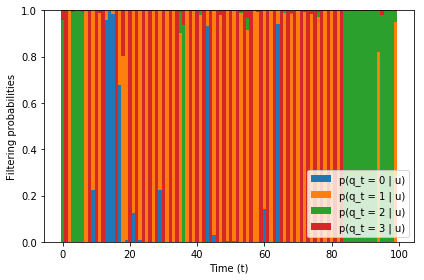

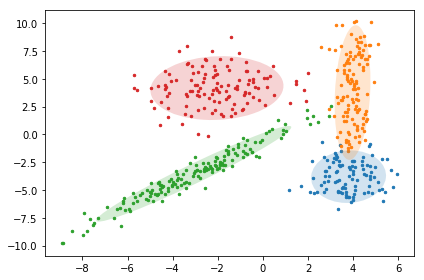

In [9]:
pi = np.ones(4) / 4
A = 1/6 * np.ones((4, 4)) + 2 / 6 * np.identity(4)

hmm = GaussianHMM(4, pi, A, HW2_means, HW2_covariances)

predictions = hmm.prediction(train)
classes = np.argmax(predictions, axis=1)
plot_predictions(predictions, 4, N=100)
plot_cluster(train, 4, classes)

## Training on the train dataset
Starting with an uniform probability transition matrix and uniform initial probability vector. Starting means and covariances have been obtained by training with the EM algorithm with a gaussian mixture model (previous homework)

means :
[[ 3.78913754 -3.97498554]
 [ 3.99448726  3.63331695]
 [-2.96885032 -3.44596464]
 [-1.95006061  4.1940554 ]]
covariances :
[[[  0.94422193   0.06115977]
  [  0.06115977   1.55346955]]

 [[  0.19771353   0.25882799]
  [  0.25882799  12.34162524]]

 [[  6.80921424   6.58540185]
  [  6.58540185   6.68647143]]

 [[  3.28400139   0.3048585 ]
  [  0.3048585    2.83136736]]]
transition matrix :
[[ 0.87859234  0.04762886  0.03420622  0.03957258]
 [ 0.01209136  0.02246886  0.03264008  0.9327997 ]
 [ 0.02011068  0.07245662  0.90067642  0.00675628]
 [ 0.04635766  0.87485905  0.06301847  0.01576482]]
initial probability :
[  1.09252619e-11   1.60898007e-16   1.00000000e+00   3.42548083e-10]


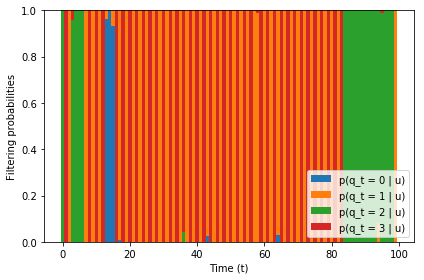

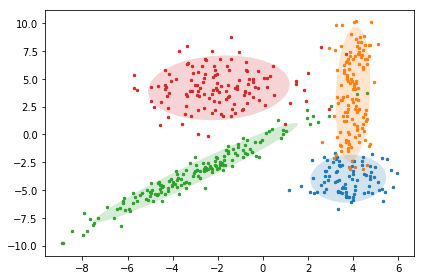

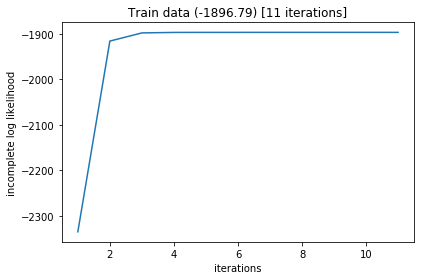

In [11]:
states = 4
pi = np.ones(states) / states
A = np.ones((states, states)) / states

hmm = GaussianHMM(4, pi, A, HW2_means, HW2_covariances)
hmm.EM(train, keep_likelihood=True)

print("means :")
print(hmm.emissions.means)

print("covariances :")
print(hmm.emissions.covariances)

print("transition matrix :")
print(hmm.transition_prob)

print("initial probability :")
print(hmm.init_prob)

predictions = hmm.prediction(train)
classes = np.argmax(predictions, axis=1)

plot_predictions(predictions, states, N=100)
plot_cluster(train, states, classes)
plot_likelihood(hmm.likelihood_history, title_prefix="Train data ")

## Training on the test dataset
Using the same starting condition as before

means :
[[ 3.89942953 -3.9103542 ]
 [ 4.03632326  3.85334554]
 [-3.1517872  -3.5998204 ]
 [-2.16956624  3.79378606]]
covariances :
[[[  1.04682115   0.16512256]
  [  0.16512256   1.1605741 ]]

 [[  0.26044037   0.09480634]
  [  0.09480634  11.3710034 ]]

 [[  5.99772485   5.6038974 ]
  [  5.6038974    5.65203953]]

 [[  3.0902434    0.04353173]
  [  0.04353173   3.43933074]]]
transition matrix :
[[ 0.86315343  0.06009879  0.03816291  0.03858487]
 [ 0.04682402  0.01234577  0.02457233  0.91625788]
 [ 0.06706816  0.02111985  0.87895891  0.03285309]
 [ 0.01077632  0.96354285  0.00663857  0.01904226]]
initial probability :
[  2.16569207e-25   9.12782880e-75   1.00000000e+00   2.59822488e-16]


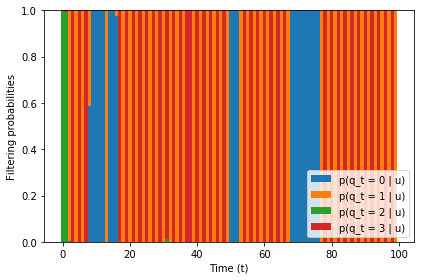

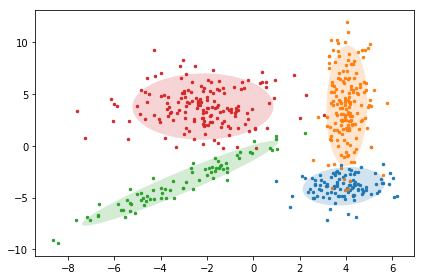

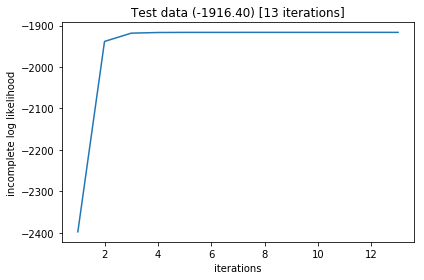

In [12]:
states = 4
pi = np.ones(states) / states
A = np.ones((states, states)) / states

hmm = GaussianHMM(4, pi, A, HW2_means, HW2_covariances)
hmm.EM(test, keep_likelihood=True)
predictions = hmm.prediction(test)
classes = np.argmax(predictions, axis=1)


print("means :")
print(hmm.emissions.means)

print("covariances :")
print(hmm.emissions.covariances)

print("transition matrix :")
print(hmm.transition_prob)

print("initial probability :")
print(hmm.init_prob)

plot_predictions(predictions, states, N=100)
# plot_predictions_decomposed(predictions, states, N=100)
plot_cluster(test, states, classes)
plot_likelihood(hmm.likelihood_history, title_prefix="Test data ")

## Experiment on a shuffled dataset
I wanted to see the effect of shuffling the dataset, we see that the transition matrix is much closer to uniform probabilities over all states

means :
[[ 3.81186923 -3.85272836]
 [ 3.96594561  3.55519392]
 [-3.06464483 -3.5377901 ]
 [-2.02817117  4.1752924 ]]
covariances :
[[[  0.95372517   0.07173437]
  [  0.07173437   1.71546788]]

 [[  0.21466437   0.36903571]
  [  0.36903571  13.28884627]]

 [[  6.23158661   6.03788641]
  [  6.03788641   6.16741972]]

 [[  2.92656464   0.21883114]
  [  0.21883114   2.76595654]]]
transition matrix :
[[ 0.19996905  0.3499525   0.20921349  0.24086496]
 [ 0.15151889  0.23916869  0.3430677   0.26624473]
 [ 0.17614891  0.24192849  0.30641757  0.27550504]
 [ 0.17891514  0.27830452  0.33284244  0.2099379 ]]
initial probability :
[  1.55762787e-26   1.26249242e-58   1.88490603e-41   1.00000000e+00]


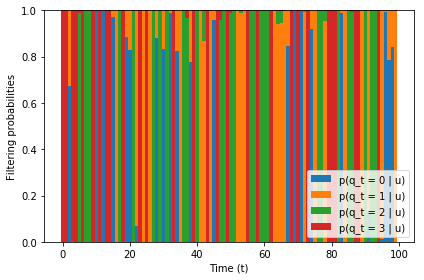

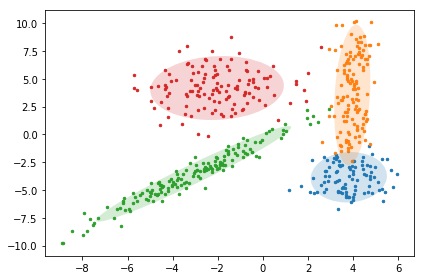

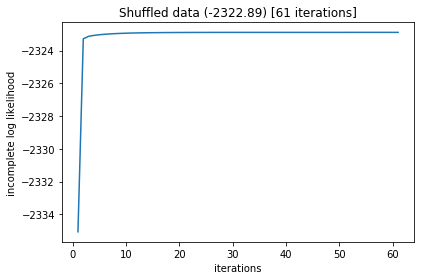

In [14]:
shuffled = train.copy()
np.random.shuffle(shuffled)
states = 4
pi = np.ones(states) / states
A = np.ones((states, states)) / states

hmm = GaussianHMM(4, pi, A, HW2_means, HW2_covariances)
hmm.EM(shuffled, keep_likelihood=True)

predictions = hmm.prediction(shuffled)
classes = np.argmax(predictions, axis=1)

print("means :")
print(hmm.emissions.means)

print("covariances :")
print(hmm.emissions.covariances)

print("transition matrix :")
print(hmm.transition_prob)

print("initial probability :")
print(hmm.init_prob)

plot_predictions(predictions, states, N=100)
plot_cluster(shuffled, states, classes)
plot_likelihood(hmm.likelihood_history, title_prefix="Shuffled data ")

## Viterbi plot

-1918.20158363


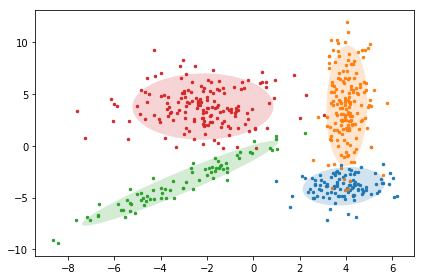

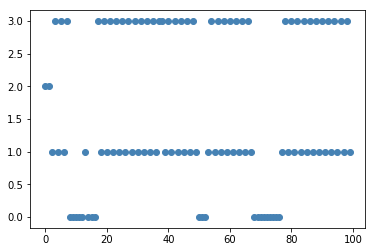

In [15]:
states = 4

pi = np.ones(states) / states
A = np.ones((states, states)) / states

hmm = GaussianHMM(4, pi, A, HW2_means, HW2_covariances)
hmm.EM(test, keep_likelihood=True)

classes_viterbi = hmm.Viterbi_2(test)

plot_cluster(test, states, classes_viterbi)
plot_classes(classes_viterbi, color="steelblue")

## Comparison with the marginal plot

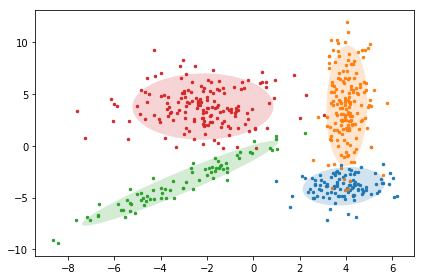

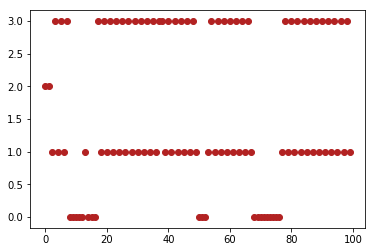

In [16]:
states = 4
pi = np.ones(states) / states
A = np.ones((states, states)) / states

hmm = GaussianHMM(4, pi, A, HW2_means, HW2_covariances)
hmm.EM(test, keep_likelihood=True)

predictions = hmm.prediction(test)
classes_marginal = np.argmax(predictions, axis=1)

plot_cluster(test, states, classes_marginal)
plot_classes(classes_marginal, color="firebrick")